<a href="https://colab.research.google.com/github/tannisthamaiti/AIWeekend-Project/blob/main/NLP_WordEmbeddings_CNN/NLP_WordEmbeddings_CNN_Solution_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, you will practice how to compute word embeddings and use them for sentiment analysis.

To implement sentiment analysis, you can go beyond counting the number of positive words and negative words.
You can find a way to represent each word numerically, by a vector.
The vector could then represent syntactic (i.e. parts of speech) and semantic (i.e. meaning) structures.
In this assignment, you will explore a classic way of generating word embeddings or representations.

You will implement a famous model called the continuous bag of words (CBOW) model.
By completing this assignment you will:



*   Train word vectors from scratch
*   Learn how to create batches of data.
*   Understand how backpropagation works.
*   Plot and visualize your learned word vectors.



Let's take a look at the following sentence:
>**'I am happy because I am learning AI'**.

- In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
- For example, if you were to choose a context half-size of say $C = 2$, then you would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

> $C$ words before: [I, am]

> $C$ words after: [because, I]

- In other words:

$$context = [I,am, because, I]$$
$$target = happy$$

Once you have encoded all the context words, you can use $\bar x$ as the input to your model.

The architecture you will be implementing is as follows:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

## Forward propagation

Let's dive into the neural network itself, which is shown below with all the dimensions and formulas you'll need.

![CBOW Model](https://github.com/tannisthamaiti/AIWeekend-Project/blob/main/images/cbow_model_dimensions_single_input.png?raw=true)

Set $N$ equal to 3. Remember that $N$ is a hyperparameter of the CBOW model that represents the size of the word embedding vectors, as well as the size of the hidden layer.

Also set $V$ equal to 5, which is the size of the vocabulary we have used so far.

In [ ]:
# Import Python libraries and helper functions (in utils2)
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from google.colab import files
from utils2 import sigmoid, get_batches, compute_pca, get_dict

In [ ]:
def get_dict(data):
    """
    Input:
        K: the number of negative samples
        data: the data you want to pull from
        indices: a list of word indices
    Output:
        word_dict: a dictionary with the weighted probabilities of each word
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    #
#     words = nltk.word_tokenize(data)
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    # return these correctly
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

In [ ]:
# Download sentence tokenizer
nltk.data.path.append('.')
#In google colab
nltk.download('punkt', download_dir='/content/nltk_data')
nltk.download('punkt_tab', download_dir='/content/nltk_data')

# Tell NLTK to look there
nltk.data.path.append('/content/nltk_data')


[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Exercise 01

In [ ]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
with open('shakespeare.txt') as f:                                  # file location https://github.com/tannisthamaiti/AIWeekend-Project/blob/main/NLP_WordEmbeddings_CNN/shakespeare.txt
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ch.lower() for ch in data if ch.isalpha()]            #  Lower case and drop non-alphabetical tokens (use isalpha, list comphrehensive)
print("Number of tokens:", len(data),'\n', data[:15])              #  print data sample

Number of tokens: 17395 
 ['the', 'sonnets', 'by', 'william', 'shakespeare', 'from', 'fairest', 'creatures', 'we', 'desire', 'increase', 'that', 'thereby', 'beauty', 'rose']


Expected Output

Number of tokens: 17395

 ['the', 'sonnets', 'by', 'william', 'shakespeare', 'from', 'fairest', 'creatures', 'we', 'desire', 'increase', 'that', 'thereby', 'beauty', 'rose']

In [ ]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.


Size of vocabulary:  3001
Most frequent tokens:  [('and', 490), ('the', 432), ('to', 408), ('my', 393), ('of', 370), ('i', 349), ('that', 323), ('in', 323), ('thy', 287), ('thou', 234), ('love', 188), ('with', 181), ('is', 180), ('not', 176), ('for', 171), ('me', 164), ('but', 163), ('a', 163), ('thee', 162), ('so', 145)]


#### Mapping words to indices and indices to words
We provide a helper function to create a dictionary that maps words to indices and indices to words.

In [ ]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  3001


Expected output:

Size of vocabulary:  3001

In [ ]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Index of the word 'Queen' :  ",word2Ind['queen'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   1404
Index of the word 'Queen' :   1983
Word which has index 2743:   upon


Expected output:

``` CCP
Index of the word 'king' :   1404

Index of the word 'king' :   1983

Word which has index 2743:   upon
```

y =WX+b

# 2 Training the Model

###  Initializing the model

You will now initialize two matrices and two vectors.
- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector.
- The second matrix ($W_2$) is of dimension $V \times N$.
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$.
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters.

<a name='ex-01'></a>
### Exercise 02
Please use [numpy.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) to generate matrices that are initialized with random values from a uniform distribution, ranging between 0 and 1.

**Note:** In the next cell you will encounter a random seed. Please **DO NOT** modify this seed so your solution can be tested correctly.

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: initialize_model
def initialize_model(N,V, random_seed=1):
    '''
    Inputs:
        N:  dimension of hidden vector
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs:
        W1, W2, b1, b2: initialized weights and biases
    '''

    np.random.seed(random_seed)

    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)
    ### END CODE HERE ###

    return W1, W2, b1, b2

In [ ]:
# Test your function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


##### Expected Output

```CPP
tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)
```

<a name='2.1'></a>
### 2.1 Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

- Array indexing in code starts at 0.
- $V$ is the number of words in the vocabulary (which is also the number of rows of $z$).
- $i$ goes from 0 to |V| - 1.


<a name='ex-02'></a>
### Exercise 03
**Instructions**: Implement the softmax function below.

- Assume that the input $z$ to `softmax` is a 2D array
- Each training example is represented by a column of shape (V, 1) in this 2D array.
- There may be more than one column, in the 2D array, because you can put in a batch of examples to increase efficiency.  Let's call the batch size lowercase $m$, so the $z$ array has shape (V, m)
- When taking the sum from $i=1 \cdots V-1$, take the sum for each column (each example) separately.

Please use
- numpy.exp
- numpy.sum (set the axis so that you take the sum of each column in z)

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: softmax
def softmax(z):
    '''
    Inputs:
        z: output scores from the hidden layer
    Outputs:
        yhat: prediction (estimate of y)
    '''

    ### START CODE HERE (Replace instances of 'None' with your own code) ###

    # Calculate yhat (softmax)
    yhat =np.exp(z)/np.sum(np.exp(z),axis=0)

    ### END CODE HERE ###

    return yhat

<a name='2.2'></a>
### 2.2 Forward propagation

<a name='ex-03'></a>
### Exercise 04
Implement the forward propagation $z$ according to equations (1) to (3). <br>

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
\end{align}

For that, you will use as activation the Rectified Linear Unit (ReLU) given by:

$$f(h)=\max (0,h) \tag{6}$$

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>You can use numpy.maximum(x1,x2) to get the maximum of two values</li>
    <li>Use numpy.dot(A,B) to matrix multiply A and B</li>
</ul>
</p>


In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: forward_prop
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs:
        x:  average one hot vector for the context
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs:
        z:  output score vector
    '''

    ### START CODE HERE (Replace instances of 'None' with your own code) ###

    # Calculate h
    h = np.dot(W1,x)+b1

    # Apply the relu on h (store result in h)
    h = np.maximum(0,h)

    # Calculate z
    z = np.dot(W2,h)+b2

    ### END CODE HERE ###

    return z, h

In [ ]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


##### Expected output
```CPP
x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]
```

<a name='2.3'></a>
## 2.3 Cost function
### Exercise 05
Implement a cross-entropy function

In [ ]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    logprobs = np.multiply(np.log(yhat),y)+ np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [ ]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (3001, 4)
tmp_y.shape (3001, 4)
tmp_W1.shape (50, 3001)
tmp_W2.shape (3001, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (3001, 1)
tmp_z.shape: (3001, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (3001, 4)
call compute_cost
tmp_cost 14.9840


##### Expected output

```CPP
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5778, 4)
call compute_cost
tmp_cost 9.9560
```

<a name='2.4'></a>
## 2.4 Training the Model - Backpropagation

<a name='ex-04'></a>
### Exercise 06
Now that you have understood how the CBOW model works, you will train it. <br>
You created a function for the forward propagation. Now you will implement a function that computes the gradients to backpropagate the errors.

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: back_prop
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs:
        x:  average one hot vector for the context
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases
        batch_size: batch size
     Outputs:
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases
    '''
    ### START CODE HERE (Replace instanes of 'None' with your code) ###

    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T,(yhat-y))
    # Apply relu to l1
    l1 = np.maximum(0,l1)
    # Compute the gradient of W1
    grad_W1 = np.dot(l1,x.T)/batch_size
    # Compute the gradient of W2
    grad_W2 = np.dot((yhat-y),h.T)/batch_size
    # Compute the gradient of b1
    grad_b1 = np.sum(l1,axis=1,keepdims=True)/batch_size
    # Compute the gradient of b2
    grad_b2 = np.sum((yhat-y),axis=1,keepdims=True)/batch_size
    ### END CODE HERE ###

    return grad_W1, grad_W2, grad_b1, grad_b2

In [ ]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (3001, 4)
tmp_y.shape (3001, 4)

Initialize weights and biases
tmp_W1.shape (50, 3001)
tmp_W2.shape (3001, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (3001, 1)

Forwad prop to get z and h
tmp_z.shape: (3001, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (3001, 4)

call back_prop
tmp_grad_W1.shape (50, 3001)
tmp_grad_W2.shape (3001, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (3001, 1)


##### Expected output

```CPP
get a batch of data
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)

Initialize weights and biases
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)

Forwad prop to get z and h
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5778, 4)

call back_prop
tmp_grad_W1.shape (50, 5778)
tmp_grad_W2.shape (5778, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5778, 1)
```

In [ ]:
def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

In [ ]:
def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0

In [ ]:
def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch = []

<a name='2.5'></a>
## Gradient Descent

<a name='ex-05'></a>
### Exercise 07
Now that you have implemented a function to compute the gradients, you will implement batch gradient descent over your training set.

**Hint:** For that, you will use `initialize_model` and the `back_prop` functions which you just created (and the `compute_cost` function). You can also use the provided `get_batches` helper function:

```for x, y in get_batches(data, word2Ind, V, C, batch_size):```

```...```

Also: print the cost after each batch is processed (use batch size = 128)

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: gradient_descent
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):

    '''
    This is the gradient_descent function

      Inputs:
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector
        V:         dimension of vocabulary
        num_iters: number of iterations
     Outputs:
        W1, W2, b1, b2:  updated matrices and biases

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)

        # Get yhat
        yhat = softmax(z)

        # Get cost
        cost = compute_cost(y, yhat, batch_size)


        if ((iters + 1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")

        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)

        # Update weights and biases
        W1 -= alpha * grad_W1
        W2 -= alpha * grad_W2
        b1 -= alpha * grad_b1
        b2 -= alpha * grad_b2

        ### END CODE HERE ###

        iters += 1
        if iters == num_iters:
            break
        if iters % 100 == 0:
            alpha *= 0.66

    return W1, W2, b1, b2

In [ ]:
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

In [ ]:
# test your function
from collections import defaultdict
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 1.354926
iters: 20 cost: 0.131973
iters: 30 cost: 0.067445
iters: 40 cost: 0.045239
iters: 50 cost: 0.034024
iters: 60 cost: 0.027262
iters: 70 cost: 0.022741
iters: 80 cost: 0.019506
iters: 90 cost: 0.017077
iters: 100 cost: 0.015186
iters: 110 cost: 0.014103
iters: 120 cost: 0.013208
iters: 130 cost: 0.012420
iters: 140 cost: 0.011720
iters: 150 cost: 0.011096


##### Expected Output


```CPP
iters: 10 cost: 0.789141
iters: 20 cost: 0.105543
iters: 30 cost: 0.056008
iters: 40 cost: 0.038101
iters: 50 cost: 0.028868
iters: 60 cost: 0.023237
iters: 70 cost: 0.019444
iters: 80 cost: 0.016716
iters: 90 cost: 0.014660
iters: 100 cost: 0.013054
iters: 110 cost: 0.012133
iters: 120 cost: 0.011370
iters: 130 cost: 0.010698
iters: 140 cost: 0.010100
iters: 150 cost: 0.009566
```

Your numbers may differ a bit depending on which version of Python you're using.

<a name='3'></a>
## 3.0 Visualizing the word vectors

In this part you will visualize the word vectors trained using the function you just coded above.

In [ ]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0

# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each

(9, 50) [1404, 1983, 1522, 1558, 2932, 2931, 2101, 1193, 2146]


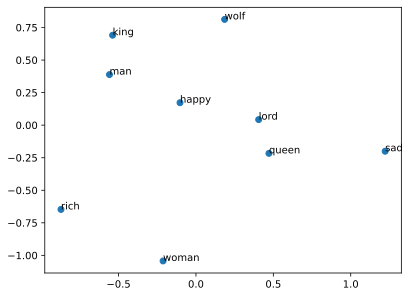

In [ ]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()